In [ ]:
#dataset link: https://www.kaggle.com/datasets/thedevastator/hate-speech-and-offensive-language-detection

In [4]:
#1.Import libraries
import json
import os
import requests
import pickle

import pandas as pd
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

from keras.utils import to_categorical
from keras import backend as K

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [40]:
#2.Read the data
DATA_PATH = "abuse_detect.csv"
LIST_PATH = "abusive_list.csv"

In [41]:
data = pd.read_csv(DATA_PATH)
data.head()
list_data=pd.read_csv(LIST_PATH)
list_data.head()

,abusive_words
0,2 girls 1 cup
1,2g1c
2,4r5e
3,5h1t
4,5hit


In [42]:
print(f"num of tweets: {data.shape}")

tweet = list(data['tweet'])
labels = list(data['class'])
abusive_words = list(list_data['abusive_words'])

num of tweets: (24783, 6)


In [8]:
#3.Data Preprocessing

stop_words = set(stopwords.words('english'))
# add rt to remove retweet in dataset (noise)
stop_words.add("rt")

# remove html entity:
def remove_entity(raw_text):
    entity_regex = r"&[^\s;]+;"
    text = re.sub(entity_regex, "", raw_text)
    return text

# change the user tags
def change_user(raw_text):
    regex = r"@([^ ]+)"
    text = re.sub(regex, "user", raw_text)

    return text

# remove urls
def remove_url(raw_text):
    url_regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    text = re.sub(url_regex, '', raw_text)

    return text

# remove unnecessary symbols
def remove_noise_symbols(raw_text):
    text = raw_text.replace('"', '')
    text = text.replace("'", '')
    text = text.replace("!", '')
    text = text.replace("`", '')
    text = text.replace("..", '')

    return text

# remove stopwords
def remove_stopwords(raw_text):
    tokenize = nltk.word_tokenize(raw_text)
    text = [word for word in tokenize if not word.lower() in stop_words]
    text = " ".join(text)

    return text

## this function in to clean all the dataset by utilizing all the function above
def preprocess(datas):
    clean = []
    # change the @xxx into "user"
    clean = [change_user(text) for text in datas]
    # remove emojis (specifically unicode emojis)
    clean = [remove_entity(text) for text in clean]
    # remove urls
    clean = [remove_url(text) for text in clean]
    # remove trailing stuff
    clean = [remove_noise_symbols(text) for text in clean]
    # remove stopwords
    clean = [remove_stopwords(text) for text in clean]

    return clean

In [9]:
clean_tweet = preprocess(tweet)

In [10]:
#4.Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(clean_tweet, labels, test_size=0.2, random_state=53)

In [11]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# vocabulary size (num of unique words) -> will be used in embedding layer
vocab_size = len(tokenizer.word_index) + 1

In [12]:
max_length = max(len(seq) for seq in X_train)

# to test an outlier case
for x in X_test:
    if len(x) > max_length:
        print(f"an outlier detected: {x}")

X_train = pad_sequences(X_train, maxlen = max_length)
X_test = pad_sequences(X_test, maxlen = max_length)

In [13]:
y_test = to_categorical(y_test, num_classes=3)
y_train = to_categorical(y_train, num_classes=3)

In [14]:
print(f"num test tweet: {y_test.shape[0]}")
print(f"num train tweet: {y_train.shape[0]}")

num test tweet: 4957
num train tweet: 19826


In [15]:
#5.Model Building
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precisions = precision(y_true, y_pred)
    recalls = recall(y_true, y_pred)
    return 2*((precisions*recalls)/(precisions+recalls+K.epsilon()))

In [16]:
output_dim = 200

# LSTM model architechture (CNN + LSTM)
model = Sequential([
    # embedding layer is like idk
    Embedding(vocab_size, output_dim, input_length=max_length),
    # lstm for xxx
    LSTM(64, dropout=0.3, recurrent_dropout=0.3),
    # dropout to prevent overfitting
    Dropout(0.5),
    # dense to connect the previous output with current layer
    Dense(128, activation="relu"),
    # dropout to prevent overfitting
    Dropout(0.5),
    # this is output layer, with 3 class (0, 1, 2)
    Dense(3, activation="softmax"),
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',f1,precision, recall])

In [17]:
# checking the model parameters
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 28, 200)           3756200   
                                                                 
 lstm (LSTM)                 (None, 64)                67840     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 3832747 (14.62 MB)
Trainable params: 38327

In [18]:
model_history = model.fit(
    X_train,
    y_train,
    batch_size = 128,
    epochs=5,
    validation_data=(X_test, y_test)
)

Epoch 1/5
155/155 [==============================] - 42s 225ms/step - loss: 0.5518 - accuracy: 0.8091 - f1: 0.7658 - precision: 0.8143 - recall: 0.7360 - val_loss: 0.3550 - val_accuracy: 0.8777 - val_f1: 0.8789 - val_precision: 0.8962 - val_recall: 0.8623
Epoch 2/5
155/155 [==============================] - 38s 243ms/step - loss: 0.2902 - accuracy: 0.9061 - f1: 0.9065 - precision: 0.9214 - recall: 0.8923 - val_loss: 0.3240 - val_accuracy: 0.8886 - val_f1: 0.8903 - val_precision: 0.9005 - val_recall: 0.8805
Epoch 3/5
155/155 [==============================] - 37s 237ms/step - loss: 0.1910 - accuracy: 0.9366 - f1: 0.9364 - precision: 0.9453 - recall: 0.9277 - val_loss: 0.3724 - val_accuracy: 0.8804 - val_f1: 0.8803 - val_precision: 0.8869 - val_recall: 0.8739
Epoch 4/5
155/155 [==============================] - 35s 225ms/step - loss: 0.1269 - accuracy: 0.9567 - f1: 0.9566 - precision: 0.9594 - recall: 0.9539 - val_loss: 0.4317 - val_accuracy: 0.8816 - val_f1: 0.8820 - val_precision: 0.88

In [19]:
print([clean_tweet[100]])

['user LMAOOOOOOOOOOO nigga user bitch want likes depressing shitfoh']


In [20]:
# with open('abuse_detect','wb') as f:
#   pickle.dump(model,f)

In [ ]:
# with open('abuse_detect','rb') as f:
#   mp=pickle.load(f)

155/155 [==============================] - 5s 23ms/step


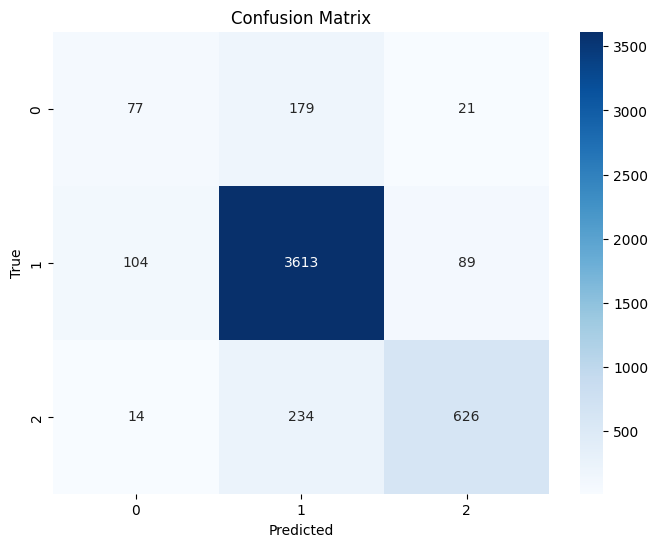

In [22]:
from sklearn.metrics import classification_report,confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

a = model.predict(X_test)

def fun(val):
  col = []
  for li in val:
    col.append(np.argmax(li))
  return col

y_pred = fun(a)
y_true = fun(y_test)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(3), yticklabels=np.arange(3))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [23]:
    from sklearn import datasets
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import classification_report, confusion_matrix

In [24]:
eval_results1 = model.evaluate(X_test, y_test, batch_size=64)
y_pred1 = model.predict(X_test, batch_size=64)
y_pred1a = fun(y_pred1)


# Generate classification report for batch_size=64
print("Classification Report for batch_size=64:")
print(classification_report(y_true, y_pred1a))

# Evaluate model with batch_size=128
eval_results2 = model.evaluate(X_test, y_test, batch_size=128)
y_pred2 = model.predict(X_test, batch_size=128)
y_pred2a = fun(y_pred2)

# Generate classification report for batch_size=128
print("Classification Report for batch_size=128:")
print(classification_report(y_true, y_pred2a))

78/78 [==============================] - 2s 23ms/step
Classification Report for batch_size=64:
              precision    recall  f1-score   support

           0       0.39      0.28      0.33       277
           1       0.90      0.95      0.92      3806
           2       0.85      0.72      0.78       874

    accuracy                           0.87      4957
   macro avg       0.71      0.65      0.68      4957
weighted avg       0.86      0.87      0.86      4957

39/39 [==============================] - 1s 24ms/step
Classification Report for batch_size=128:
              precision    recall  f1-score   support

           0       0.39      0.28      0.33       277
           1       0.90      0.95      0.92      3806
           2       0.85      0.72      0.78       874

    accuracy                           0.87      4957
   macro avg       0.71      0.65      0.68      4957
weighted avg       0.86      0.87      0.86      4957



In [25]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.39      0.28      0.33       277
           1       0.90      0.95      0.92      3806
           2       0.85      0.72      0.78       874

    accuracy                           0.87      4957
   macro avg       0.71      0.65      0.68      4957
weighted avg       0.86      0.87      0.86      4957



In [26]:
  print(confusion_matrix(y_true, y_pred))

[[  77  179   21]
 [ 104 3613   89]
 [  14  234  626]]


In [43]:
# Function to predict and mark abusive words with asterisks
def predict_and_mark(text):
    text_seq = tokenizer.texts_to_sequences([preprocess(text)])
    text_padded = pad_sequences(text_seq, maxlen=max_length, padding='post')
    prediction = model.predict(text_padded).argmax()

    if prediction<=2:
        marked_text = ''.join(['* ' if word in abusive_words else (word+" ") for word in text.split()])
    else:
        marked_text = text

    return marked_text



In [45]:
# Example usage
text_to_check = input("Enter Text:")
marked_text = predict_and_mark(text_to_check)
# print(f"Original text: {text_to_check}")
print(f"Marked text: {marked_text}")

Enter Text:user LMAOOOOOOOOOOO nigga user bitch want likes depressing shitfoh
1/1 [==============================] - 0s 25ms/step
Marked text: user LMAOOOOOOOOOOO * user * want likes depressing shitfoh 
